# Data Analytics Project - US STATE CRIME (1960-2019)
<br>
<br>

Authors: Agnieszka Welian, Katarzyna Wątorska
<br>
Date: 21-06-2022

<div style  = "text-align: justify">Crime statistics are made available for public review by the Unified Crime Reporting Statistics under the collaboration of the U.S. Department of Justice and the Federal Bureau of Investigation. The following data set has information on the crime rates and totals for each state across the United States that has been collected over the years 1960 - 2019. The crime reports are divided into two main categories: property crime and violent crime. Property crime refers to burglary, larceny, and motor related crime, while violent crime refers to assault, murder, rape and robbery. </div>

<div style='text-align:justify'>The main goal of this project is to describe the burglary rate and investigate the correlation between two types of crimes: burglary and larceny for the California state.
Thre created models may help in getting bigger insight into the phenomenon of these two crimes, the possible correlation between them and be a beginning of the task of forecasting crime occurrence, as well as evaluating police effectiveness. </div>

The data come from: https://think.cs.vt.edu/corgis/csv/state_crime/ and are a repost from the FBI website. Crime rates are reported per 100 000 inhabitants.

<div style='text-align:justify'>Two different models were chosen to model crime rates - normal distribution and linear model. 
Research provided the information that mean of the burglary rate is approximately equal to 1300 and its standard deviation is approximately equal to 600. Taking that into account, normal distribution with parameters $\mu$ = 1300, $\sigma$ = 600 has been introduced.
Linear model uses a predictor - larceny rate. Those before mentioned data are used to construct an alpha parameter $\alpha = normal(1300, 600)$. The beta and sigma have distributions: $\beta = lognormal(1, 0)$, $\sigma = exponential(0.00167)$ (giving the uncertanity of 600).
The first model checks if it is possible to describe the given burglary rates with a normal distribution, whereas the second one tries to predict burglary rates basing on larceny rates.
<br>
    

</div> 
When it comes to the normal model we focus on it in the form:

$$ ~ \mathrm{Normal}(\mu,\sigma) $$
<br>
When it comes to the linear model we focus on it in the form:

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$
<br>
Both models assume some uncertainty, but in case of linear models the mean $\mu$ is a value calculated from linear equations (Taylor simplified series) - in case of normal models, it is always generated.
<br>
In those models adding any other parameter does not make sense unless, instead of finding the correlation, the main goal was to predict the value. For properly using the models, some data is required. For the normal model, there is a need to know the mean and standard deviation. For the linear model, the above mentioned parameters are needed, too, but there is also an additional input which is the 'X' in the equation. It is a data from which our model depends.

</div>

# 1. Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
import scipy.stats as stats
import arviz as az
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi'] = 200

In [2]:
#functions for ribbon plot
light = "#E0FFFF"
light_highlight = "#AFEEEE"
mid = "#40E0D0"
mid_highlight = "#48D1CC"
dark = "#0000FF"
dark_highlight = "#6495ED"
green = "#008000"
light_grey = "#DDDDDD"
import warnings
def is_sorted(a):
    '''Check if numpy 1d-array is sorted
    '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a)))
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape))
    return np.all(a[:-1] <= a[1:])

def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array; type(x)={}, type(fx)={}'.format(type(x), type(fx)))
    if len(x) != fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {}, got {}'.format(len(x), fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x, axis = 0), fx], axis = 0)
    sortedArr = arr2D[:, arr2D[0].argsort()]
    return sortedArr[0, :], sortedArr[1:, :]

def get_quantiles(fx, probs = None):
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even')
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)')
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2))))
    return np.percentile(fx, probs, axis=0)
def ribbon_plot(x, fx, ax = None, zorder = 0, probs = None, supress_warning = False):
    '''Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x).
    x has shape (n, )
    fx has shape (N, n)
    '''
    if ax is None:
        ax = plt.gca()
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx)
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")    
    perc_interv = get_quantiles(fx, probs)
    nq = perc_interv.shape[0]
    colortab = [light, light_highlight, mid, mid_highlight, dark, dark_highlight]

    for i in range(int(nq/2)):
        ax.fill_between(x,
                        perc_interv[i,:],
                        perc_interv[-(i+1),:],
                        color = colortab[i],
                        zorder = zorder)
    ax.plot(x, perc_interv[int(nq/2),:], color = colortab[int(nq/2)], zorder = zorder)
    return ax

In [3]:
#read the data from the csv file
df = pd.read_csv("state_crime.csv")
df.head()

,State,Year,Data.Population,Data.Rates.Property.All,Data.Rates.Property.Burglary,Data.Rates.Property.Larceny,Data.Rates.Property.Motor,Data.Rates.Violent.All,Data.Rates.Violent.Assault,Data.Rates.Violent.Murder,...,Data.Rates.Violent.Robbery,Data.Totals.Property.All,Data.Totals.Property.Burglary,Data.Totals.Property.Larceny,Data.Totals.Property.Motor,Data.Totals.Violent.All,Data.Totals.Violent.Assault,Data.Totals.Violent.Murder,Data.Totals.Violent.Rape,Data.Totals.Violent.Robbery
0,Alabama,1960,3266740,1035.4,355.9,592.1,87.3,186.6,138.1,12.4,...,27.5,33823,11626,19344,2853,6097,4512,406,281,898
1,Alabama,1961,3302000,985.5,339.3,569.4,76.8,168.5,128.9,12.9,...,19.1,32541,11205,18801,2535,5564,4255,427,252,630
2,Alabama,1962,3358000,1067.0,349.1,634.5,83.4,157.3,119.0,9.4,...,22.5,35829,11722,21306,2801,5283,3995,316,218,754
3,Alabama,1963,3347000,1150.9,376.9,683.4,90.6,182.7,142.1,10.2,...,24.7,38521,12614,22874,3033,6115,4755,340,192,828
4,Alabama,1964,3407000,1358.7,466.6,784.1,108.0,213.1,163.0,9.3,...,29.1,46290,15898,26713,3679,7260,5555,316,397,992


In [4]:
#print column names
df.columns

Index(['State', 'Year', 'Data.Population', 'Data.Rates.Property.All',
       'Data.Rates.Property.Burglary', 'Data.Rates.Property.Larceny',
       'Data.Rates.Property.Motor', 'Data.Rates.Violent.All',
       'Data.Rates.Violent.Assault', 'Data.Rates.Violent.Murder',
       'Data.Rates.Violent.Rape', 'Data.Rates.Violent.Robbery',
       'Data.Totals.Property.All', 'Data.Totals.Property.Burglary',
       'Data.Totals.Property.Larceny', 'Data.Totals.Property.Motor',
       'Data.Totals.Violent.All', 'Data.Totals.Violent.Assault',
       'Data.Totals.Violent.Murder', 'Data.Totals.Violent.Rape',
       'Data.Totals.Violent.Robbery'],
      dtype='object')

In [5]:
#choose 1 state
california = df[df["State"] == "California"]

<div style = "text-align: justify">During basic analysis different crime rates were plotted on a scatter graph with x-axis displaying years. It is visible that the data seems to be flawed - most graphs have 3 points (for years 2013 - 2015) that do not fit the general trend line. Some data manipulation helped to determine that there must have occurred an intermingling of the data between different columns. For larceny, the records from the mentioned range of time, were found in the column of motor crime rates. For burglary, the data were fitted from the larceny column. Verification of the data from the FBI website confirmed that the hipothesis is correct. Thus, appropriate corrections have been introduced to the dataset. </div>

Text(0.5, 1.0, 'Data before processing')

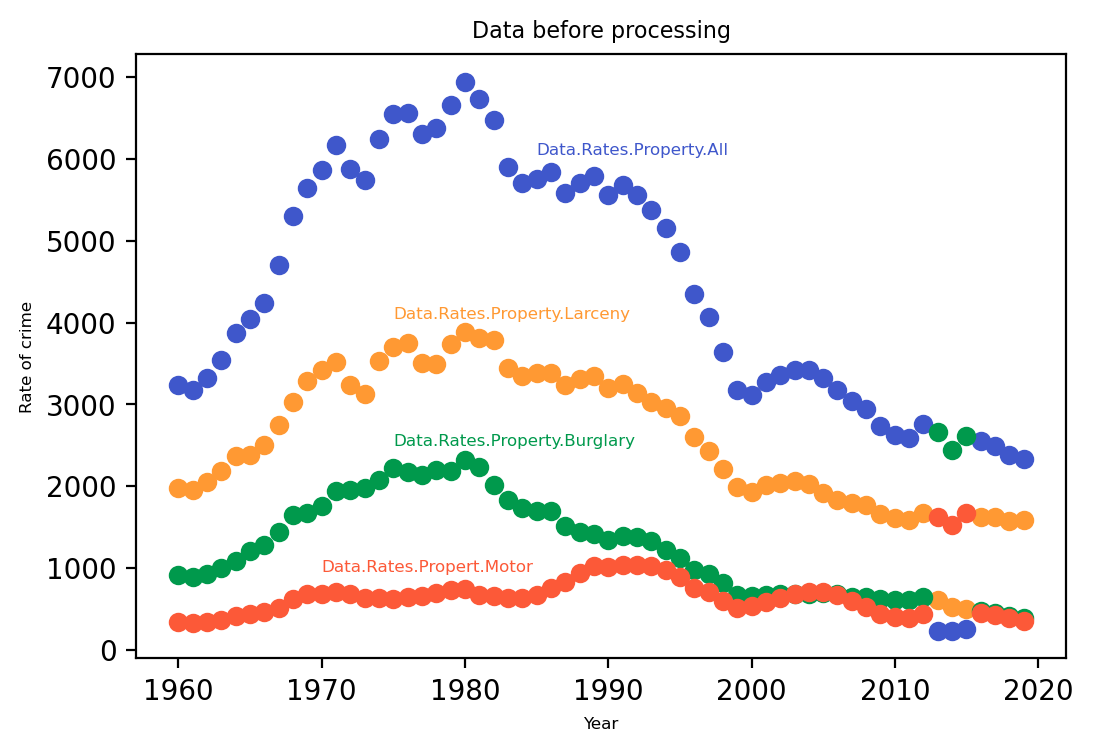

In [6]:
#plot raw data for all property crime rates, larceny, burglary and motor crime rates
fig,ax = plt.subplots()
plt.rc('xtick', labelsize=5)
plt.rc('ytick', labelsize=5)
plt.rcParams.update()
ax.scatter(data=california, x = 'Year', y = 'Data.Rates.Property.All', color = '#3F57CB')
ax.scatter(data=california, x = 'Year', y = 'Data.Rates.Property.Larceny', color = '#FF9933')
ax.scatter(data=california, x = 'Year', y = 'Data.Rates.Property.Burglary', color = '#00994C')
ax.scatter(data=california, x = 'Year', y = 'Data.Rates.Property.Motor', color = '#FC5938')
ax.text(1985, 6050, 'Data.Rates.Property.All', fontsize = 6, color = '#3F57CB')
ax.text(1975, 4050, 'Data.Rates.Property.Larceny', fontsize = 6, color = '#FF9933')
ax.text(1975, 2500, 'Data.Rates.Property.Burglary', fontsize = 6, color = '#00994C')
ax.text(1970, 950, 'Data.Rates.Propert.Motor', fontsize = 6, color = '#FC5938')
plt.xlabel('Year', fontsize = 6)
plt.ylabel('Rate of crime', fontsize = 6)
plt.title("Data before processing", fontsize = 8)

<div style = 'text-align: justify'>It can be observed, that until 1970s the crime rates were increasing, to achieve peaks around 1980, flatten and start dropping in 1990s. By 2000 the crime rates returned to values similar to those at the beginning of the measurement, in 1960. Such a shape of the graph might be connected with the high unemployment rate in the years 1970 - 1985. The inflation rate was also considerable (13.3% in 1979 https://www.thebalance.com/u-s-inflation-rate-history-by-year-and-forecast-3306093) during the time with the increased crime rates. The years for which the data has been collected encompass a period of escalating tension between the USA and the Soviet Union. This situation obviously exerted an enormous impact on the economy and politics. 
The increased crime rates in the second half of the 20th century may be connected with the military conflicts that the USA were engaged in. There is a hipothesis that societies experience increased civil violence after participating in wars and also uphold a legitimation of violence model (https://www.ojp.gov/ncjrs/virtual-library/abstracts/increases-us-violent-crime-during-1980s-following-four-american). In the years 1963 - 1975 the American army was involved in the Vietnam war - the conflict being still vivid in the nation's memory. In 1979 it participated in the Soviet-Afghan war, in 1982-1984 in the Lebanese Civil War, in 1983 the Army took part in the invasion of Grenada and in 1989 - 1990 in the invasion of Panama, to name but a few. 
After the attacks on 9/11, the rate of white-collar crimes (the full range of frauds committed by business and government professionals) increased, due to rellocation of the FBI resources to fight with terrorism (https://hbswk.hbs.edu/item/white-collar-crime-enforcement). It is possible that also other kinds of crimes could become more frequent. 
Worth mentioning is that in the USA quite high rates of discrimination against race or ethnicity are still observed and they also may contribute to the crime rate. 
<br> 
<br>
To decreasing crime rates contribute decreasing homelessness (by 16% in the years 2007-2019) and poverty (decreased by around 3% to 12.5% in the years 2010 - 2020) (https://my.neighbor.org/california-homelessness-statistics/#:~:text=Homelessness%20in%20California,-Each%20night%20more&text=In%20the%20last%20point-in,entirety%20of%20the%20United%20States.).
The lower crime rates may be also connected with growing immigrant population. According to American Immigration Council, immgrants are less likely to commit a crime and to be incancerated than native-borns.The foreign-born population in California has been growing from 8.8% in 1970 to 27.2% in 2020 (https://www.americanimmigrationcouncil.org/research/criminalization-immigration-united-states). 
    
</div> 

In [7]:
#corrections of dataset
for i in range(0, len(df)):
    if df['Data.Rates.Property.All'][i] <  df['Data.Rates.Property.Burglary'][i]:
        x = df['Data.Rates.Property.All'][i]
        df['Data.Rates.Property.All'][i] =  df['Data.Rates.Property.Burglary'][i]
        df['Data.Rates.Property.Burglary'][i] = x
    if df['Data.Rates.Property.Larceny'][i] <  df['Data.Rates.Property.Motor'][i]:
        y = df['Data.Rates.Property.Larceny'][i]
        df['Data.Rates.Property.Larceny'][i] =  df['Data.Rates.Property.Motor'][i]
        df['Data.Rates.Property.Motor'][i] = y
    if df['Data.Rates.Property.Burglary'][i] <  df['Data.Rates.Property.Motor'][i]:
        z = df['Data.Rates.Property.Burglary'][i]
        df['Data.Rates.Property.Burglary'][i] =  df['Data.Rates.Property.Motor'][i]
        df['Data.Rates.Property.Motor'][i] = z

C:\Users\Agnieszka\AppData\Local\Temp\ipykernel_14440\3248312617.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Data.Rates.Property.All'][i] =  df['Data.Rates.Property.Burglary'][i]
C:\Users\Agnieszka\AppData\Local\Temp\ipykernel_14440\3248312617.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Data.Rates.Property.Burglary'][i] = x
C:\Users\Agnieszka\AppData\Local\Temp\ipykernel_14440\3248312617.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Text(0.5, 1.0, 'Data after the correction')

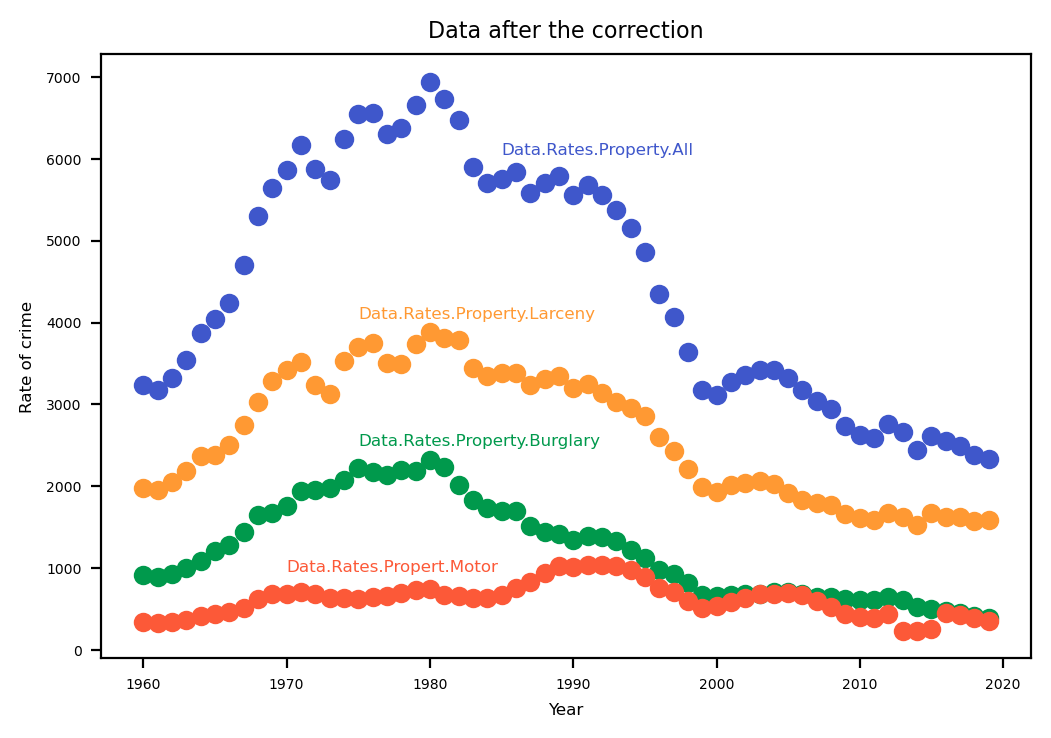

In [8]:
#plot corrected data
california = df[df["State"] == "California"]
fig,ax = plt.subplots()

ax.scatter(data=california, x = 'Year', y = 'Data.Rates.Property.All', color = '#3F57CB')
ax.scatter(data=california, x = 'Year', y = 'Data.Rates.Property.Larceny', color = '#FF9933')
ax.scatter(data=california, x = 'Year', y = 'Data.Rates.Property.Burglary', color = '#00994C')
ax.scatter(data=california, x = 'Year', y = 'Data.Rates.Property.Motor', color = '#FC5938')
ax.text(1985, 6050, 'Data.Rates.Property.All', fontsize = 6, color = '#3F57CB')
ax.text(1975, 4050, 'Data.Rates.Property.Larceny', fontsize = 6, color = '#FF9933')
ax.text(1975, 2500, 'Data.Rates.Property.Burglary', fontsize = 6, color = '#00994C')
ax.text(1970, 950, 'Data.Rates.Propert.Motor', fontsize = 6, color = '#FC5938')

plt.xlabel('Year', fontsize = 6)
plt.ylabel('Rate of crime', fontsize = 6)
plt.title("Data after the correction", fontsize = 8)

The motor crime rates still seem to be not well-matched, but since this project does not concentrate on motor realted crimes, it is left so.

In [9]:
california.describe()

,Year,Data.Population,Data.Rates.Property.All,Data.Rates.Property.Burglary,Data.Rates.Property.Larceny,Data.Rates.Property.Motor,Data.Rates.Violent.All,Data.Rates.Violent.Assault,Data.Rates.Violent.Murder,Data.Rates.Violent.Rape,Data.Rates.Violent.Robbery,Data.Totals.Property.All,Data.Totals.Property.Burglary,Data.Totals.Property.Larceny,Data.Totals.Property.Motor,Data.Totals.Violent.All,Data.Totals.Violent.Assault,Data.Totals.Violent.Murder,Data.Totals.Violent.Rape,Data.Totals.Violent.Robbery
count,60.000000,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.00000,60.000000,60.000000,6.000000e+01,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.00000,60.000000,60.000000
mean,1989.500000,2.855579e+07,4475.756667,1228.918333,2620.975000,616.905000,617.291667,339.663333,7.89000,34.218333,224.545000,1.163731e+06,3.580828e+05,691070.750000,201472.483333,178274.266667,99361.366667,2207.50000,9654.166667,62802.366667
std,17.464249,7.628299e+06,1478.502570,594.524257,778.947315,207.456626,242.850555,152.225295,3.11365,10.450099,104.734474,4.012412e+05,1.865597e+05,203269.217232,119409.517507,79088.695892,51175.017672,870.82368,3161.458981,30578.344402
min,1960.000000,1.571720e+07,2331.200000,386.100000,1527.400000,232.300000,232.700000,119.600000,3.70000,17.400000,19.500000,8.902900e+04,1.431020e+05,197404.000000,53453.000000,37558.000000,18796.000000,605.00000,2859.000000,7464.000000
25%,1974.750000,2.111550e+07,3177.725000,674.300000,1922.125000,443.275000,440.800000,241.225000,4.87500,25.300000,147.475000,9.858202e+05,2.317542e+05,620181.750000,139242.500000,136046.000000,53445.500000,1744.25000,8280.000000,48528.250000
50%,1989.500000,2.941151e+07,4294.700000,1164.950000,2555.650000,635.600000,572.700000,319.050000,6.85000,34.150000,198.450000,1.185550e+06,3.209860e+05,695103.000000,168435.500000,180857.000000,99075.500000,2188.50000,9872.500000,62310.000000
75%,2004.250000,3.592007e+07,5760.975000,1708.150000,3346.200000,696.875000,801.500000,410.650000,10.60000,41.650000,311.450000,1.492620e+06,4.356690e+05,859776.750000,241611.000000,210350.250000,136183.250000,2772.25000,11997.750000,84399.500000
max,2019.000000,3.955704e+07,6939.500000,2316.500000,3880.000000,1038.900000,1119.700000,641.600000,14.50000,58.200000,424.100000,1.726391e+06,1.024914e+06,986120.000000,656517.000000,345624.000000,198045.000000,4096.00000,15505.000000,130897.000000


In [10]:
california['Data.Rates.Property.Burglary'].describe()


count      60.000000
mean     1228.918333
std       594.524257
min       386.100000
25%       674.300000
50%      1164.950000
75%      1708.150000
max      2316.500000
Name: Data.Rates.Property.Burglary, dtype: float64

In [11]:
california['Data.Rates.Property.Larceny'].describe()

count      60.000000
mean     2620.975000
std       778.947315
min      1527.400000
25%      1922.125000
50%      2555.650000
75%      3346.200000
max      3880.000000
Name: Data.Rates.Property.Larceny, dtype: float64

# 2. Normal model - Prior predictive check

In this section it is presented an attempt to fit the Normal(µ, σ) distribution to the burglary rate in California. 

In [12]:
#the prior model
with open('normal_ppc.stan', 'r') as file:
    print(file.read())

generated quantities {
  real mu = normal_rng(1300, 600);  
  real <lower = 0> sigma = exponential_rng(0.00167); 
  real burglary = normal_rng(mu, sigma);
}


As is was mentioned before, the parameters are based on the research and it was check if the selected parameters "make sense". The mean is equal to 1300 and the standard deviation to 600. It was also assumed that the values may differ from the reality - that is why it was decided to add the uncertainity equal to 600 (1/0.00167).

In [13]:
normal_model1 = CmdStanModel(stan_file = 'normal_ppc.stan')

R = 1000 
sim_normal = normal_model1.sample(iter_sampling = R, 
                             iter_warmup = 0,
                             chains = 1,
                             fixed_param = True,
                             seed = 31052022)

mu_normal_ppc = sim_normal.stan_variable('mu')
sigma_normal_ppc = sim_normal.stan_variable('sigma')
burglary_normal_ppc = sim_normal.stan_variable('burglary')

INFO:cmdstanpy:compiling stan file C:\Users\Agnieszka\Desktop\aaaa\normal_ppc.stan to exe file C:\Users\Agnieszka\Desktop\aaaa\normal_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\Users\Agnieszka\Desktop\aaaa\normal_ppc.exe
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


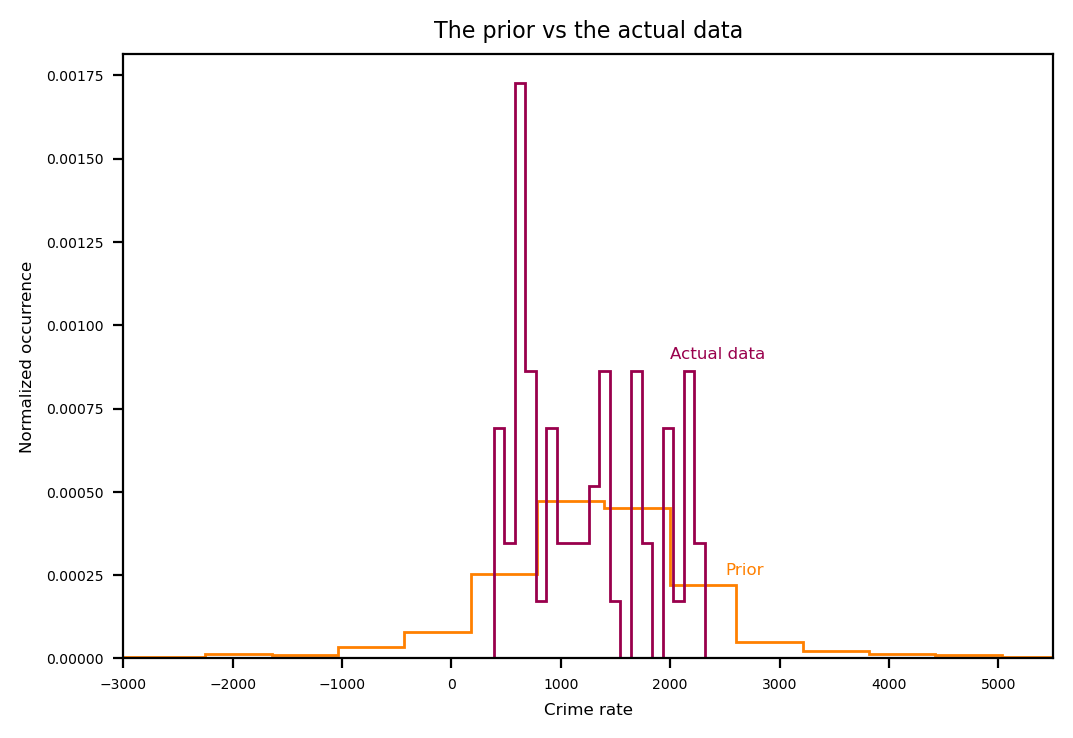

In [14]:
#histogram comparing the prior and the actual data
plt.hist(burglary_normal_ppc, bins=20, label= "Prior", histtype='step', color = '#ff8000', density = True)
plt.hist(california['Data.Rates.Property.Burglary'], bins=20, label= "Actual data", 
         histtype='step', color = '#99004c', density = True)

plt.xlabel('Crime rate', fontsize = 6)
plt.ylabel('Normalized occurrence', fontsize = 6)
plt.xlim([-3000, 5500])
plt.text(2000, 0.000900, 'Actual data', fontsize = 6, color = '#99004C')
plt.text(2500, 0.00025, 'Prior', fontsize = 6, color = '#FF8000')
plt.title('The prior vs the actual data', fontsize = 8)
plt.show()

<div style="text-align:justify">The prior seems to fit the actual data quite well. It encompases the whole data range, however, is not able to detect the initial peak (crime rate around 700) and the final peak (around 2200). Also range of values is quite big. </div>

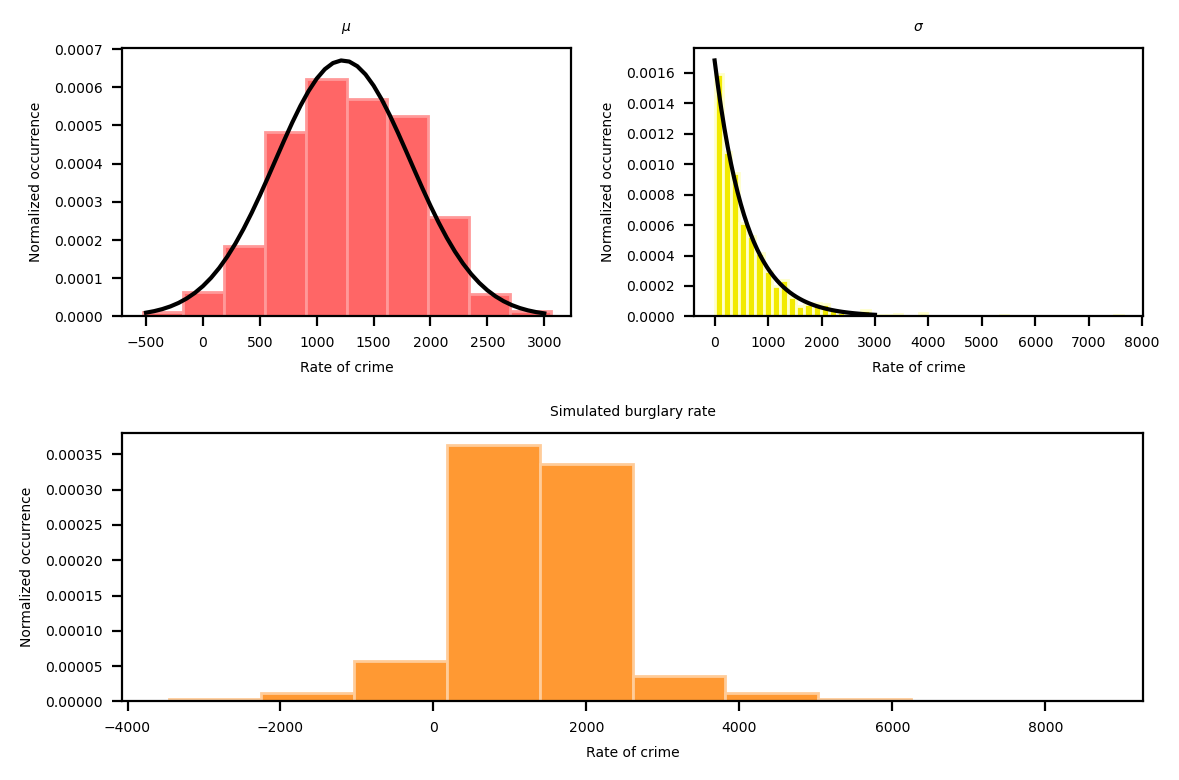

In [15]:
#histograms of mean, standard deviation and burglary rate from the prior - comparison with real data
fig = plt.figure()
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[1, :])
ax1.hist(burglary_normal_ppc, bins = 10, density = True, color = '#ff9933', edgecolor = '#ffcc99')
ax1.set_title('Simulated burglary rate', fontsize=5)
plt.xlabel('Rate of crime', fontsize=5)
plt.ylabel('Normalized occurrence', fontsize=5)

ax2 = fig.add_subplot(gs[0, 0])
ax2.hist(mu_normal_ppc, bins = 10, density = True, color= '#FF6666', edgecolor = '#ff9999')
x = np.linspace(-500, 3000)
y = stats.norm.pdf(x, loc = 1229, scale = 595)
ax2.plot(x, y, 'black')
ax2.set_title('$\mu$', fontsize = 5)
plt.xlabel('Rate of crime', fontsize = 5)
plt.ylabel('Normalized occurrence', fontsize = 5)

ax3 = fig.add_subplot(gs[0, 1])
ax3.hist(sigma_normal_ppc, bins = 50, density = True, color = '#f2ea00', edgecolor = '#ffffcc')
x = np.linspace(0, 3000)
y = stats.expon.pdf(x, scale = 595)
ax3.plot(x, y, color = 'black')
ax3.set_title('$\sigma$', fontsize = 5)
plt.xlabel('Rate of crime', fontsize = 5)
plt.ylabel('Normalized occurrence', fontsize = 5)
fig.tight_layout()
plt.show()

The graphs display the comparison of actual mean and standard deviation distributions with the ones extracted from the prior model. The overall result is quite satisfying. Values of $\mu$ are quite good fitted to the course of the normal model distribution with data from the dataset. The $\sigma$ values likewise fit the course of exponential function.

# 3. Normal model - Posterior and inference

The following model has been introduced: 

In [16]:
#the posterior model
with open('normal_fit.stan', 'r') as file:
    print(file.read())

data {
    int N;
    real burglaries[N];
}

parameters {
   real mu;
   real <lower = 0> sigma;
}

model {
    mu ~ normal(1300, 600);
    sigma ~ exponential(0.00167);
    burglaries ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    real burglary;
    for (j in 1:N)
    {
        log_lik[j] = normal_lpdf(burglaries[j] | mu, sigma);
    }
    burglary = normal_rng(mu, sigma);
}


In [17]:
normal_fit = CmdStanModel(stan_file = 'normal_fit.stan')
stan_data={"N": len(california), "burglaries": california['Data.Rates.Property.Burglary']}

R = 1000
sim_normal_fit = normal_fit.sample(data=stan_data, iter_sampling = R, 
                             iter_warmup = 1000,
                             fixed_param = False,  
                             chains = 4, seed = 31052022)

mu_normal_fit = sim_normal_fit.stan_variable('mu')
sigma_normal_fit = sim_normal_fit.stan_variable('sigma')
burglary_normal_fit = sim_normal_fit.stan_variable('burglary')

INFO:cmdstanpy:compiling stan file C:\Users\Agnieszka\Desktop\aaaa\normal_fit.stan to exe file C:\Users\Agnieszka\Desktop\aaaa\normal_fit.exe
INFO:cmdstanpy:compiled model executable: C:\Users\Agnieszka\Desktop\aaaa\normal_fit.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Agnieszka/Desktop/aaaa/normal_fit.hpp C:/Users/Agnieszka/Desktop/aaaa/normal_fit.stan
Warning in 'C:/Users/Agnieszka/Desktop/aaaa/normal_fit.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-variable -Wno-sign-compare -Wno-unused-local-typedefs -Wno-int-in-bool-context -Wno-attributes -Wno-ignored-attributes      -I s


INFO:cmdstanpy:CmdStan done processing.


There were no sampling issues.

In [18]:
sim_normal_fit.diagnose()

'Processing csv files: C:\\Users\\AGNIES~1\\AppData\\Local\\Temp\\tmpsnf73ktk\\normal_fit-20220619192149_1.csv, C:\\Users\\AGNIES~1\\AppData\\Local\\Temp\\tmpsnf73ktk\\normal_fit-20220619192149_2.csv, C:\\Users\\AGNIES~1\\AppData\\Local\\Temp\\tmpsnf73ktk\\normal_fit-20220619192149_3.csv, C:\\Users\\AGNIES~1\\AppData\\Local\\Temp\\tmpsnf73ktk\\normal_fit-20220619192149_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [19]:
az.summary(sim_normal_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1230.328,78.507,1074.700,1373.490,1.354,0.957,3378.0,2681.0,1.0
sigma,601.163,57.346,496.802,707.196,1.083,0.771,2846.0,2657.0,1.0
burglary,1248.431,614.761,125.410,2404.940,10.113,7.152,3697.0,3639.0,1.0


<div style='text-align:justify'>The obtained mean value of the burglary is near the mean value of the real data (1229). Similarly, the obtained standard deviation (595) is close to the real value. When focusing on those two values, it can be said that the  model is similar to the actual data, but taking into account only mean and standard deviation might be misleading. A better way to assess the model performence is to compare the values of the posterior data and actual data on one histogram with normalized y-axis. </div>

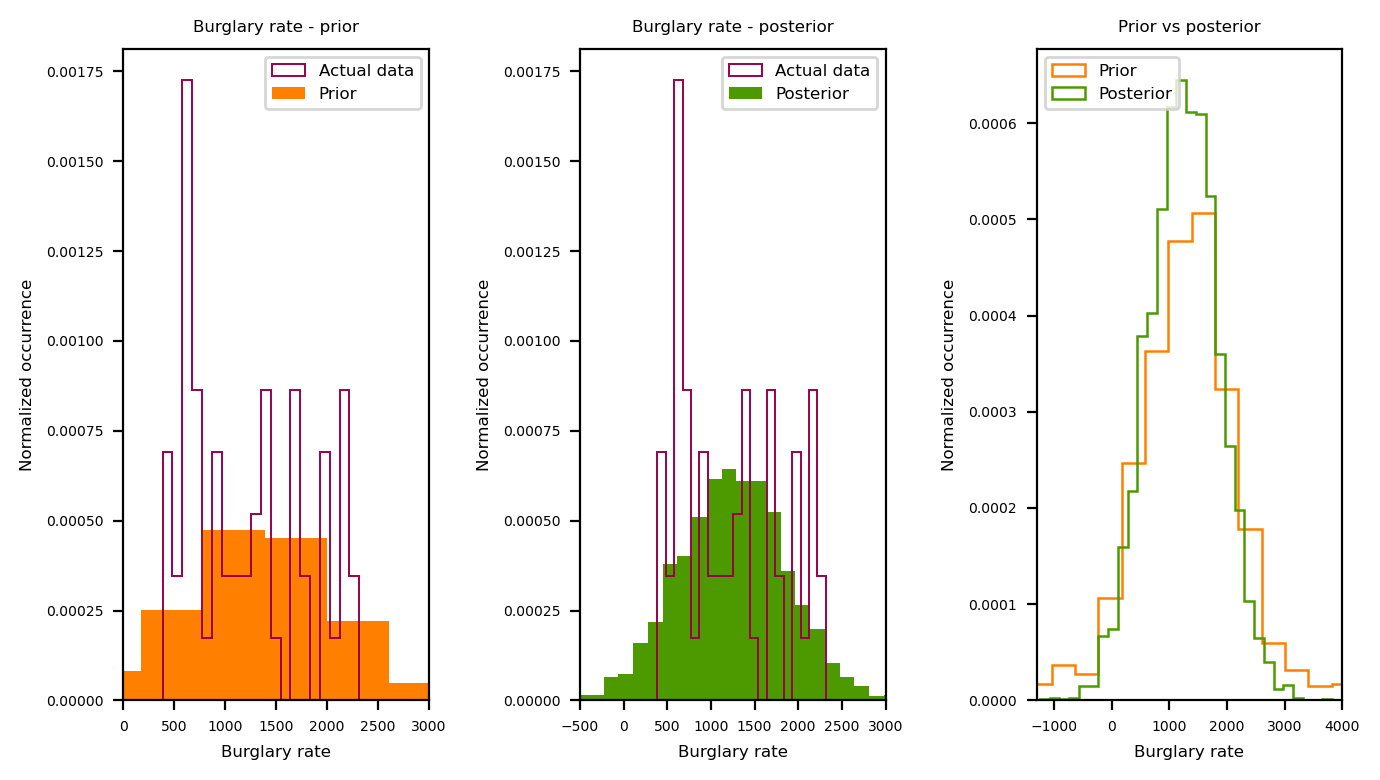

In [20]:
#comparison of the prior, posterior and actual data
fig, axes = plt.subplots(1, 3, figsize = (7, 4), sharex = False, sharey = False)
ax = axes[0]
ax.hist(california['Data.Rates.Property.Burglary'], bins = 20,histtype = 'step', density = True, 
        linewidth= 0.7, color = '#99004c', label = 'Actual data')
ax.hist(burglary_normal_ppc, bins = 20, density = True, color = '#ff8000', label = 'Prior')
ax.set_title('Burglary rate - prior', fontsize = 6)
ax.set_xlim(0, 3000)
ax.set_xlabel('Burglary rate', fontsize = 6)
ax.set_ylabel('Normalized occurrence', fontsize = 6)
ax.legend(prop={'size':6}, loc = 'upper right')

ax2 = axes[1]
ax2.hist(california['Data.Rates.Property.Burglary'], bins = 20, histtype = 'step', color = '#99004c', 
         linewidth= 0.7, density = True, label='Actual data')
ax2.hist(burglary_normal_fit, bins = 30, density = True, color = '#4c9900', label = 'Posterior')
ax2.set_title('Burglary rate - posterior',fontsize = 6)
ax2.set_xlim([-500, 3000])
ax2.set_xlabel('Burglary rate',fontsize = 6)
ax2.set_ylabel('Normalized occurrence',fontsize = 6)
ax2.legend(prop={'size':6}, loc = 'upper right')

ax3 = axes[2]
ax3.hist(burglary_normal_ppc, bins = 30, histtype = 'step', color = '#ff8000', label = 'Prior', 
         linewidth= 0.9, density = True)
ax3.hist(burglary_normal_fit, bins = 30, density = True, label = 'Posterior', histtype='step',
         color = '#4c9900', linewidth= 0.9)

ax3.set_title('Prior vs posterior', fontsize = 6)

ax3.set_xlim([-1300, 4000])
ax3.set_xlabel('Burglary rate', fontsize = 6)
ax3.set_ylabel('Normalized occurrence', fontsize = 6)
ax3.legend(prop={'size':6}, loc = 'upper left')

fig.tight_layout()
plt.show()

<div style='text-align:justify'>
The posterior data seem to be slightly better fitted than the prior data. However, judging from the histogram, the distant values do not play a big role. The peak in the actual data is still not detected by the normal model. Peak in Normal model is slightly shifted to right (due to setting the values in $\mu$ to 1300 and 600).
    The posterior shows a typical normal distrbution shape, whereas the actual data histogram does not fit it well. The model is not able to show the higher values around the rate of 700 and smaller or none around the rates of 1500 and 2000. The posterior data encompases wider data range, proposing also minus crime rates. Thus, normal distribution model does not seem to be able to model this phenomenon. It would better fit if its shape were more positively-skewed and the mean value was shifted towards the left, at around 750 (but that is not the actual mean value of this crime rate). The posterior includes narrower burglary rates than the prior, which is a good, expected behaviour. The histograms below are a comparision of the prior and the posterior generated mean value and standard deviation. </div>

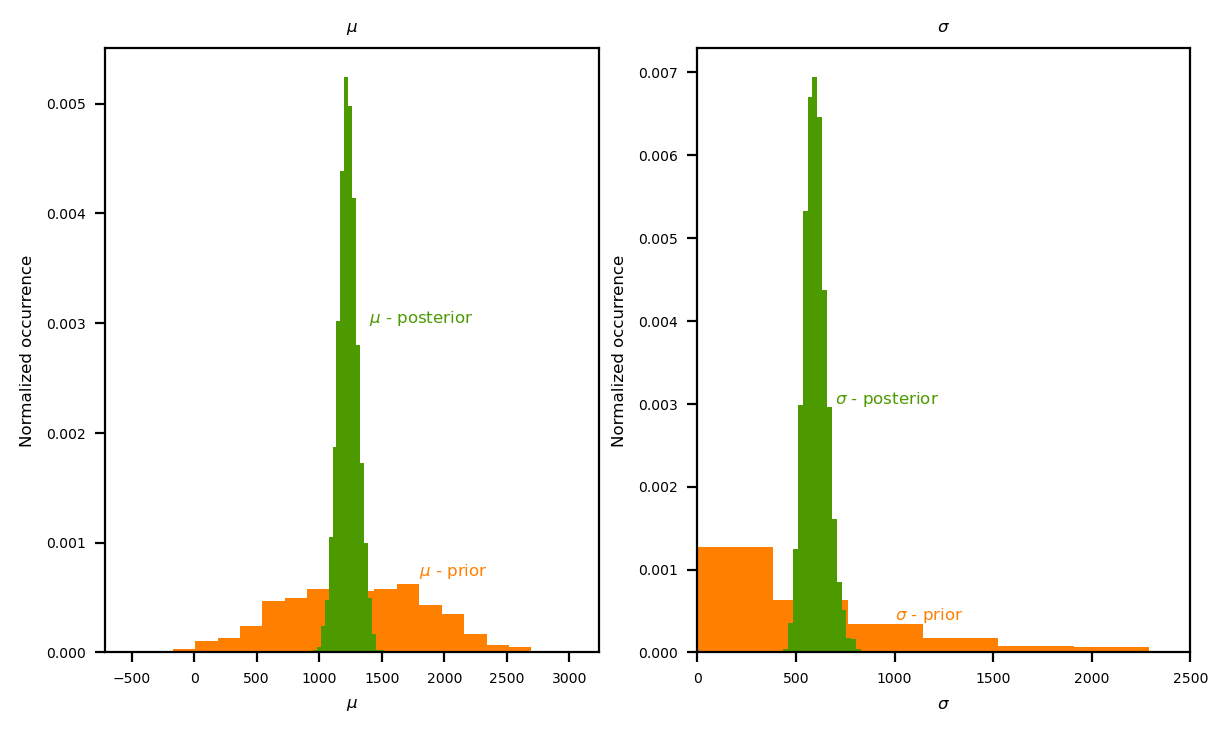

In [21]:
#comparison of the prior and posterior calculated parameters
fig, axes = plt.subplots(1, 2, figsize = (7, 4), sharex = False, sharey = False)
ax = axes[0]
ax.hist(mu_normal_ppc, bins = 20, label = 'Prior', density = True, color = '#ff8000')
ax.hist(mu_normal_fit, bins = 20, label = 'Posterior', density = True, color = '#4c9900')
ax.set_title('$\mu$', fontsize = 6)

ax.set_xlabel('$\mu$', fontsize = 6)
ax.set_ylabel('Normalized occurrence', fontsize = 6)
ax.text(1400,0.003, '$\mu$ - posterior', fontsize = 6, color = '#4c9900')
ax.text(1800, 0.0007, '$\mu$ - prior', fontsize = 6, color = '#ff8000')

ax2 = axes[1]
ax2.hist(sigma_normal_ppc, bins = 20, density = True, label = 'Prior', color = '#ff8000')
ax2.hist(sigma_normal_fit, bins = 20, density = True, label = 'Posterior', color = '#4c9900')
ax2.set_title('$\sigma$',fontsize = 6)
ax2.set_xlim([0, 2500])
ax2.set_xlabel('$\sigma$',fontsize = 6)
ax2.set_ylabel('Normalized occurrence',fontsize = 6)
ax2.text(700, 0.003, '$\sigma$ - posterior', fontsize = 6, color = '#4c9900')
ax2.text(1000, 0.0004, '$\sigma$ - prior', fontsize = 6, color = '#ff8000')
plt.show()

Both values of $\mu$ are normally distributed around the set value of the mean (1300). Yet, the posterior mean is significantly more concise than the prior mean which reaches biggers values. The posterior standard deviation histogram seems to be normally distributed, too. It contrasts the prior $\sigma$ to a large extent.

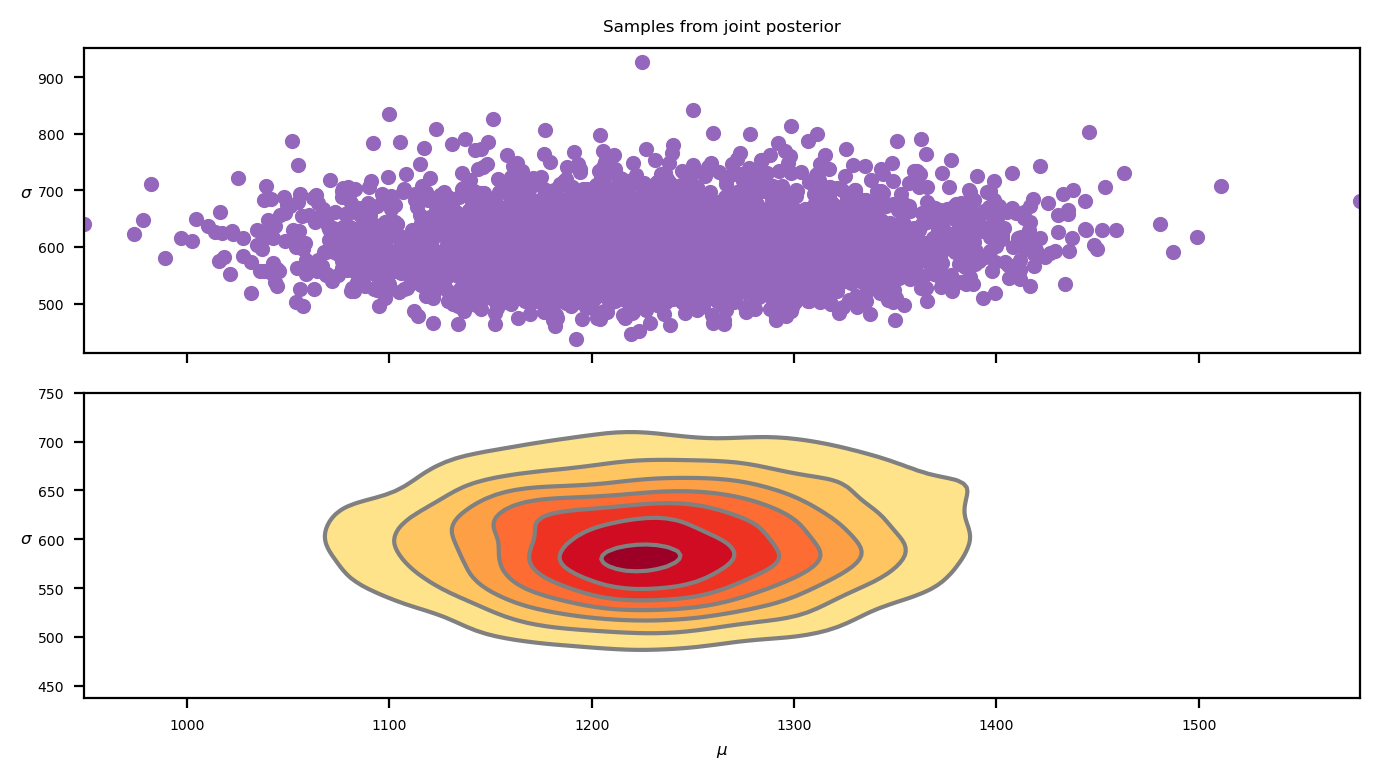

In [22]:
#samples from joint posterior
fig, axes = plt.subplots(2,1, figsize = (7,4), sharex = True)
ax1 = axes[0]
ax1.scatter(mu_normal_fit, sigma_normal_fit, 20,  color = '#9467bd')
ax1.set_ylabel(r'$\sigma$', rotation = 0, fontsize = 6)
ax1.set_title('Samples from joint posterior', fontsize = 6)

ax2 = axes[1]
az.plot_kde(mu_normal_fit, sigma_normal_fit, ax = ax2, contourf_kwargs = {'cmap': 'YlOrRd'})
ax2.set_ylabel(r'$\sigma$', rotation = 0, fontsize = 6)
ax2.set_xlabel(r'$\mu$', fontsize = 6)
fig.tight_layout()
plt.ylim(top = 750)
plt.show()

# 4. Linear model - Prior predictive check

<div style='text-align:justify'>To improve the analysis of the crime rates in California, a linear model is introduced. It predicts burglary rate, using predictor of larceny rate. They mean value and standard deviatoin of burglary rate were used to construct an alpha parameter. The predictor is centered by substracting the mean value of larceny rate calculated from the actual data. </div>

In [23]:
california['c_Data.Rates.Property.Larceny'] = (california['Data.Rates.Property.Larceny'] - california['Data.Rates.Property.Larceny'].mean())
california.head()

C:\Users\Agnieszka\AppData\Local\Temp\ipykernel_14440\3045216782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  california['c_Data.Rates.Property.Larceny'] = (california['Data.Rates.Property.Larceny'] - california['Data.Rates.Property.Larceny'].mean())


,State,Year,Data.Population,Data.Rates.Property.All,Data.Rates.Property.Burglary,Data.Rates.Property.Larceny,Data.Rates.Property.Motor,Data.Rates.Violent.All,Data.Rates.Violent.Assault,Data.Rates.Violent.Murder,...,Data.Totals.Property.All,Data.Totals.Property.Burglary,Data.Totals.Property.Larceny,Data.Totals.Property.Motor,Data.Totals.Violent.All,Data.Totals.Violent.Assault,Data.Totals.Violent.Murder,Data.Totals.Violent.Rape,Data.Totals.Violent.Robbery,c_Data.Rates.Property.Larceny
240,California,1960,15717204,3235.4,910.5,1984.8,340.1,239.0,119.6,3.9,...,508511,143102,311956,53453,37558,18796,616,2859,15287,-636.175
241,California,1961,16397000,3177.5,894.2,1950.6,332.7,232.7,120.0,3.7,...,521008,146615,319834,54559,38154,19684,605,3033,14832,-670.375
242,California,1962,16970000,3326.2,934.1,2052.9,339.2,234.8,121.7,3.9,...,564451,158523,348373,57555,39846,20645,657,2946,15598,-568.075
243,California,1963,17590000,3545.8,998.9,2184.7,362.2,241.2,126.3,3.8,...,623709,175703,384289,63717,42419,22208,673,3080,16458,-436.275
244,California,1964,18084000,3874.3,1088.7,2366.5,419.1,265.6,138.2,4.1,...,700630,196883,427960,75787,48026,24998,740,3621,18667,-254.475


In [24]:
#prior linear model
with open('linear_ppc.stan', 'r') as file:
    print(file.read())

data {
   int N;
   real larceny[N];
}

generated quantities {
   real alpha = normal_rng(1300, 600);
   real beta = lognormal_rng(0,1);
   real <lower = 0> sigma = exponential_rng(0.00167);
   real <lower = 0> burglary[N];
   for (i in 1:N) {
      burglary[i] = normal_rng(larceny[i]*beta + alpha, sigma);
   }
}


In [25]:
normal_model1 = CmdStanModel(stan_file = 'linear_ppc.stan')
stan_data={'N': len(california["Data.Rates.Property.Larceny"]),
           "larceny": np.linspace(california["c_Data.Rates.Property.Larceny"].min(),
                                  california["c_Data.Rates.Property.Larceny"].max(), num = 60)}

R = 1000
sim_linear_ppc = normal_model1.sample(data=stan_data, iter_sampling = R, 
                             iter_warmup = 0,
                             chains = 1,
                             fixed_param = True,
                             seed = 31052022)

alpha_linear_ppc = sim_linear_ppc.stan_variable('alpha')
beta_linear_ppc = sim_linear_ppc.stan_variable('beta')
sigma_linear_ppc = sim_linear_ppc.stan_variable('sigma')
burglary_linear_pcc = sim_linear_ppc.stan_variable('burglary')

INFO:cmdstanpy:compiling stan file C:\Users\Agnieszka\Desktop\aaaa\linear_ppc.stan to exe file C:\Users\Agnieszka\Desktop\aaaa\linear_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\Users\Agnieszka\Desktop\aaaa\linear_ppc.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Agnieszka/Desktop/aaaa/linear_ppc.hpp C:/Users/Agnieszka/Desktop/aaaa/linear_ppc.stan
Warning in 'C:/Users/Agnieszka/Desktop/aaaa/linear_ppc.stan', line 3, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Agnieszka/Desktop/aaaa/linear_ppc.stan', line 10, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatical

INFO:cmdstanpy:CmdStan done processing.


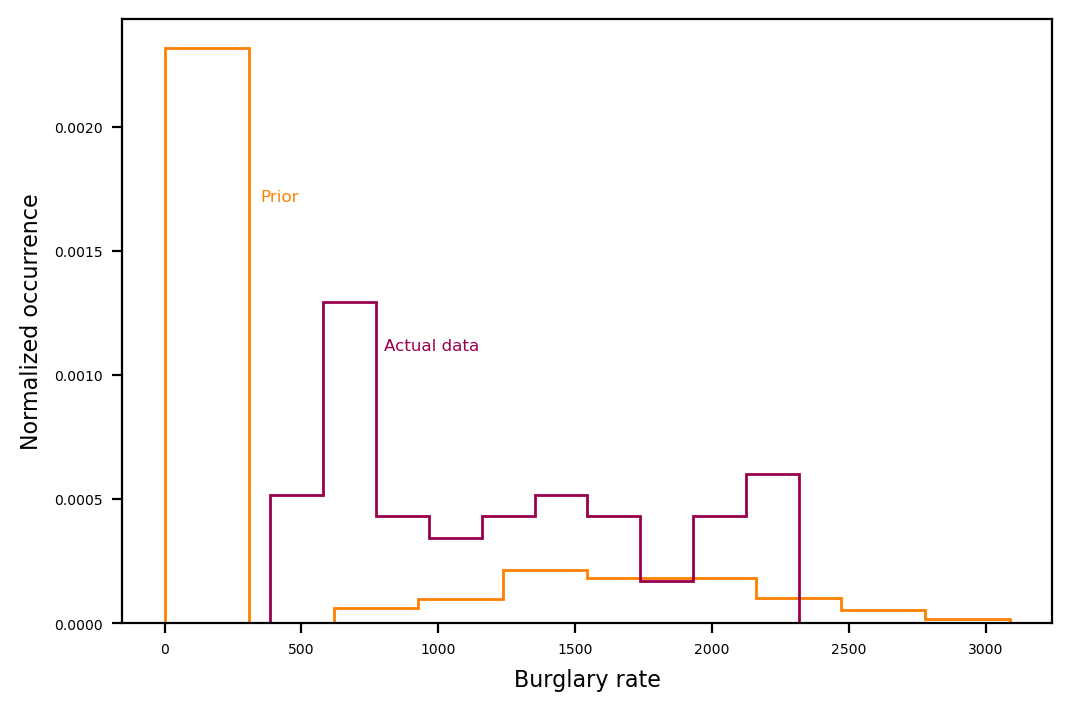

In [26]:
#histograms comparing prior and actual data
burglary_mean_ppc = np.mean(burglary_linear_pcc, axis = 1)
plt.hist(burglary_mean_ppc, bins=10, label= "Prior", histtype='step', density = True, color = '#ff8000')
plt.hist(california['Data.Rates.Property.Burglary'], bins=10, label= "Actual data", histtype='step',
         color = '#99004c', density = True)

plt.text(350, 0.0017, 'Prior', fontsize = 6, color = '#ff8000')
plt.text(800, 0.0011, 'Actual data', fontsize = 6, color = '#99004c')
plt.xlabel('Burglary rate', fontsize = 8)
plt.ylabel('Normalized occurrence', fontsize = 8)
plt.show()

The prior is able to detect the initial peak (at around 700), yet is is shifted too much to the left.

Text(0, 0.5, 'Simulated burglary rate')

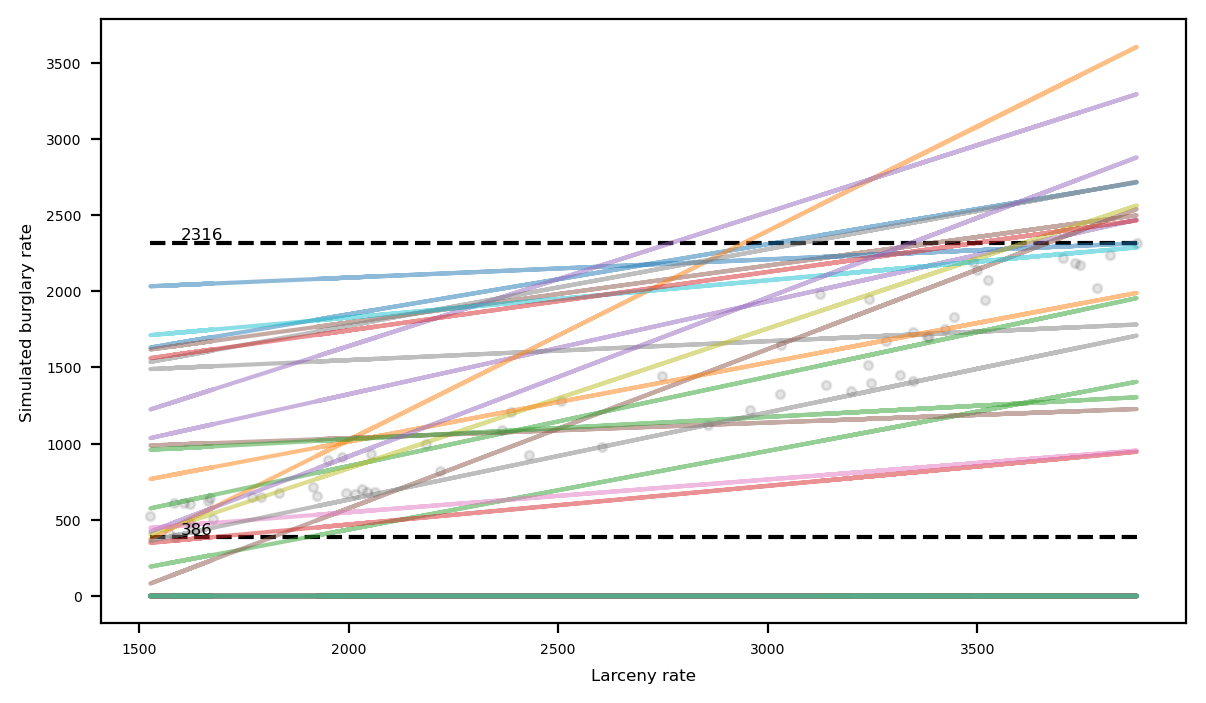

In [27]:
#comparision of prior outcomes
fig, axes = plt.subplots(1,1, figsize = (7,4))
axes.hlines([386, 2316], xmin = california['Data.Rates.Property.Larceny'].min(), 
            xmax = california['Data.Rates.Property.Larceny'].max(), linestyle = '--', color = 'black')
for i in range(60):
    axes.plot(california['Data.Rates.Property.Larceny'], 
              alpha_linear_ppc[i] + beta_linear_ppc[i]*california['c_Data.Rates.Property.Larceny'], alpha = 0.5)
axes.scatter(california['Data.Rates.Property.Larceny'], california['Data.Rates.Property.Burglary'], 
             color = 'black', alpha = 0.1, s=10)
axes.text(1600, 2340, '2316', fontsize = 6)
axes.text(1600, 405, '386', fontsize = 6)
axes.set_xlabel('Larceny rate', fontsize = 6)
axes.set_ylabel('Simulated burglary rate', fontsize = 6)

It is visible that for smaller values of larceny rates, smaller values of burglary rates are proposed. Most of the lines fall into the range [386, 2316] of burglary rates .

# 5. Linear model - posterior 

In [28]:
#posterior linear model
with open('linear_fit.stan', 'r') as file:
    print(file.read())

data {
   int N;
   vector[N] larceny;
   real burglaries[N];
}

parameters {
   real alpha;
   real beta;
   real <lower=0> sigma;
}

transformed parameters {
   vector[N] mu = larceny*beta+alpha;
}

model {
   alpha ~ normal(1300, 600);
   beta ~ lognormal(0, 1);
   sigma ~ exponential(0.00167);
   burglaries ~ normal(mu, sigma);
}

generated quantities {
   array [N] real burglary;
   vector[N] log_lik;
   for (i in 1:N) {
       burglary[i] = normal_rng(mu[i], sigma);
       log_lik[i] = normal_lpdf(burglaries[i] | mu[i], sigma);
   }
}


In [29]:
linear_fit_model = CmdStanModel(stan_file = 'linear_fit.stan')
stan_data={'N': len(california["Data.Rates.Property.Larceny"]), "larceny": 
           california["c_Data.Rates.Property.Larceny"],
           "burglaries": california["Data.Rates.Property.Burglary"] }


R = 1000
sim_linear_fit = linear_fit_model.sample(data=stan_data, iter_sampling = R, 
                             iter_warmup = 1000,
                             fixed_param=False,
                             chains = 4,
                             seed = 31052022) 

alpha_linear_fit = sim_linear_fit.stan_variable('alpha')
beta_linear_fit = sim_linear_fit.stan_variable('beta')
sigma_linear_fit = sim_linear_fit.stan_variable('sigma')
mu_linear_fit = sim_linear_fit.stan_variable('mu')
burglary_linear_fit = sim_linear_fit.stan_variable('burglary')

INFO:cmdstanpy:compiling stan file C:\Users\Agnieszka\Desktop\aaaa\linear_fit.stan to exe file C:\Users\Agnieszka\Desktop\aaaa\linear_fit.exe
INFO:cmdstanpy:compiled model executable: C:\Users\Agnieszka\Desktop\aaaa\linear_fit.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Agnieszka/Desktop/aaaa/linear_fit.hpp C:/Users/Agnieszka/Desktop/aaaa/linear_fit.stan
Warning in 'C:/Users/Agnieszka/Desktop/aaaa/linear_fit.stan', line 4, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-variable -Wno-sign-compare -Wno-unused-local-typedefs -Wno-int-in-bool-context -Wno-attributes -Wno-ignored-attributes      -I s


INFO:cmdstanpy:CmdStan done processing.


There were no sampling issues.

In [30]:
sim_linear_fit.diagnose()

'Processing csv files: C:\\Users\\AGNIES~1\\AppData\\Local\\Temp\\tmpsnf73ktk\\linear_fit-20220619192403_1.csv, C:\\Users\\AGNIES~1\\AppData\\Local\\Temp\\tmpsnf73ktk\\linear_fit-20220619192403_2.csv, C:\\Users\\AGNIES~1\\AppData\\Local\\Temp\\tmpsnf73ktk\\linear_fit-20220619192403_3.csv, C:\\Users\\AGNIES~1\\AppData\\Local\\Temp\\tmpsnf73ktk\\linear_fit-20220619192403_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [31]:
az.summary(sim_linear_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1228.649,21.648,1190.970,1273.040,0.341,0.241,4032.0,2772.0,1.0
beta,0.732,0.028,0.678,0.785,0.000,0.000,4424.0,3169.0,1.0
sigma,169.911,15.813,142.007,201.271,0.251,0.181,4038.0,2725.0,1.0
mu[0],762.803,28.204,706.760,812.462,0.443,0.313,4079.0,2967.0,1.0
mu[1],737.760,28.832,681.098,789.021,0.452,0.320,4086.0,2984.0,1.0
...,...,...,...,...,...,...,...,...,...
burglary[55],538.273,172.950,212.918,848.871,2.732,1.932,4001.0,3931.0,1.0
burglary[56],503.152,174.132,173.828,817.737,2.883,2.064,3655.0,3963.0,1.0
burglary[57],498.761,177.600,176.195,837.319,2.967,2.098,3580.0,3821.0,1.0
burglary[58],457.599,171.757,146.741,802.657,2.802,2.020,3760.0,3567.0,1.0


Text(1700, 410, '386')

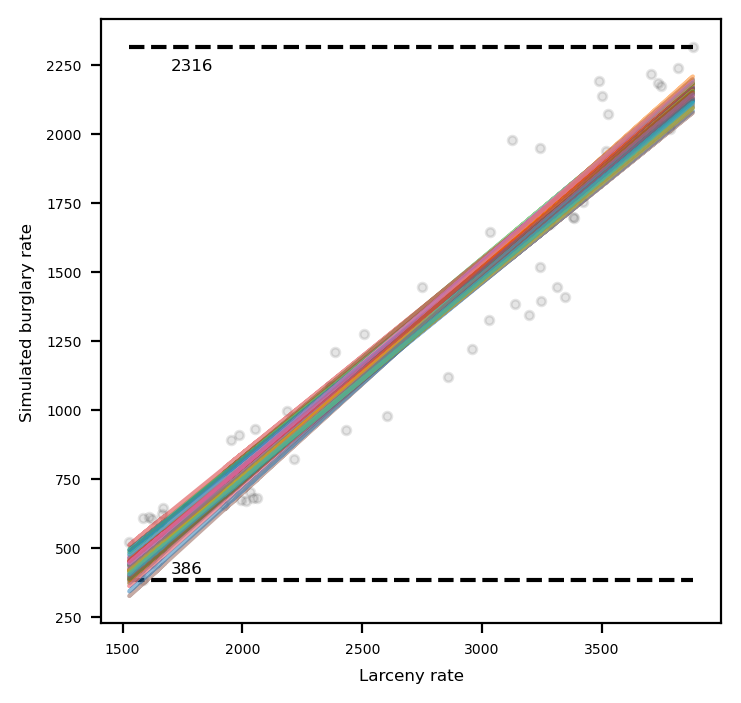

In [32]:
#comparision of posterior outcomes
fig, axes = plt.subplots(1,1, figsize = (4,4))
axes.hlines([386, 2316], xmin = california['Data.Rates.Property.Larceny'].min(), 
            xmax = california['Data.Rates.Property.Larceny'].max(), linestyle = '--', color = 'black')
for i in range(60):
    axes.plot(california['Data.Rates.Property.Larceny'], 
              alpha_linear_fit[i] + beta_linear_fit[i]*california['c_Data.Rates.Property.Larceny'], alpha = 0.5)
axes.scatter(california['Data.Rates.Property.Larceny'], california['Data.Rates.Property.Burglary'], 
             color = 'black', alpha = 0.1, s=10)
axes.set_xlabel('Larceny rate', fontsize = 6)
axes.set_ylabel('Simulated burglary rate', fontsize = 6)
axes.text(1700, 2230, '2316', fontsize = 6)
axes.text(1700, 410, '386', fontsize = 6)

The outcomes obtained from the posterior are much more concise that the ones from the prior and fit better the actual data. 

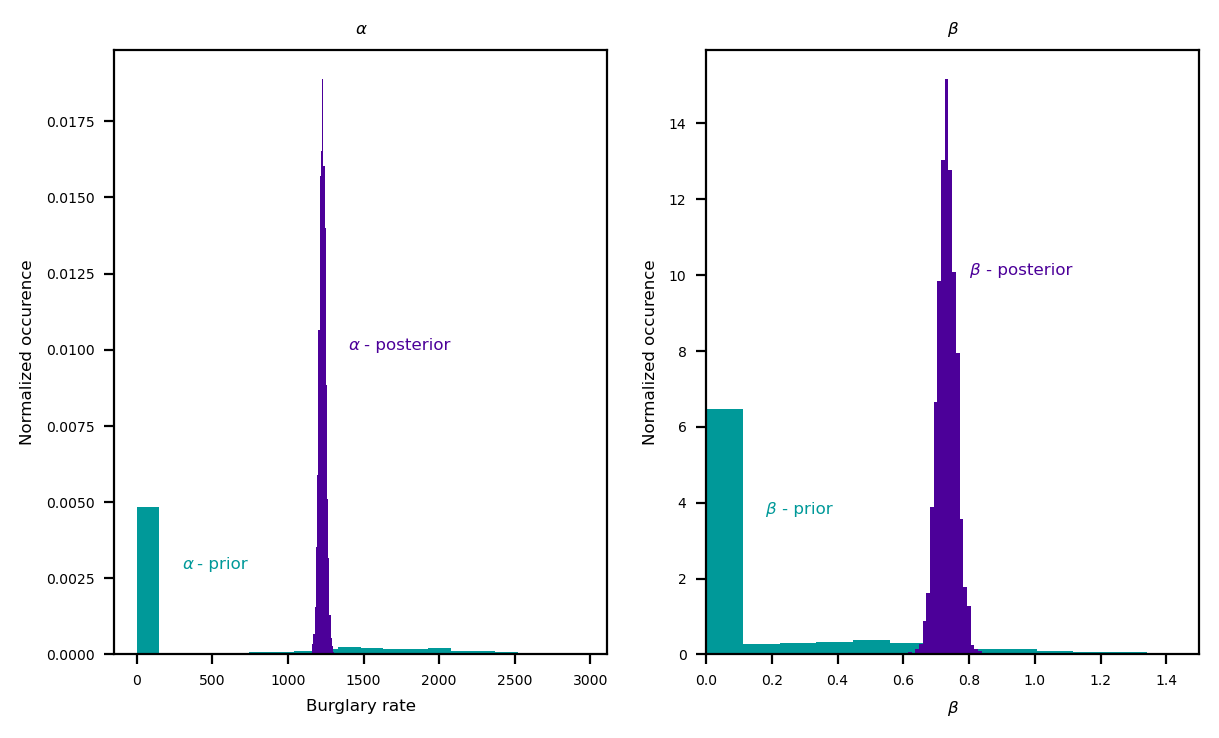

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(7,4))
ax = axes[0]
ax.hist(alpha_linear_ppc, bins = 20, label = 'Prior',color = '#009999' ,density = True, linewidth = 0.5)
ax.hist(alpha_linear_fit, bins = 20, label = 'Posterior',color = '#4c0099' ,density = True)
ax.set_xlabel('Burglary rate', fontsize = 6)
ax.set_ylabel('Normalized occurence', fontsize = 6)
ax.set_title(r'$\alpha$', fontsize = 6)
ax.text(1400, 0.01, r'$\alpha$', fontsize = 6, color = '#4c0099')
ax.text(1500, 0.01, '- posterior', fontsize = 6, color = '#4c0099')
ax.text(300, 0.0028, r'$\alpha$', fontsize = 6, color = '#009999')
ax.text(400, 0.0028, '- prior', fontsize = 6, color = '#009999')
ax2.set_xlim([0, 2500])

ax2 = axes[1]
ax2.hist(beta_linear_ppc, bins = 20, label = 'Prior',color = '#009999' ,density = True, linewidth = 0.5)
ax2.hist(beta_linear_fit, bins = 20, density = True, label = 'Posterior', color = '#4c0099')
ax2.set_title(r'$\beta$', fontsize = 6)
ax2.set_xlabel(r'$\beta$', fontsize = 6)
ax2.set_ylabel('Normalized occurence', fontsize = 6)

ax2.text(0.8, 10, r'$\beta$', fontsize = 6, color = '#4c0099')
ax2.text(0.85, 10, '- posterior', fontsize = 6, color = '#4c0099')

ax2.text(0.18, 3.7, r'$\beta$', fontsize = 6,color='#009999')
ax2.text(0.23, 3.7, '- prior', fontsize = 6,color='#009999')
ax2.set_xlim([0, 1.5])
plt.show()

Both $\alpha$ and $\beta$ from the posterior seem to be normally distributed. They achieve bigger values than the prior parameters. Posterior values are more concise and are distributed according to given parameters in the model.

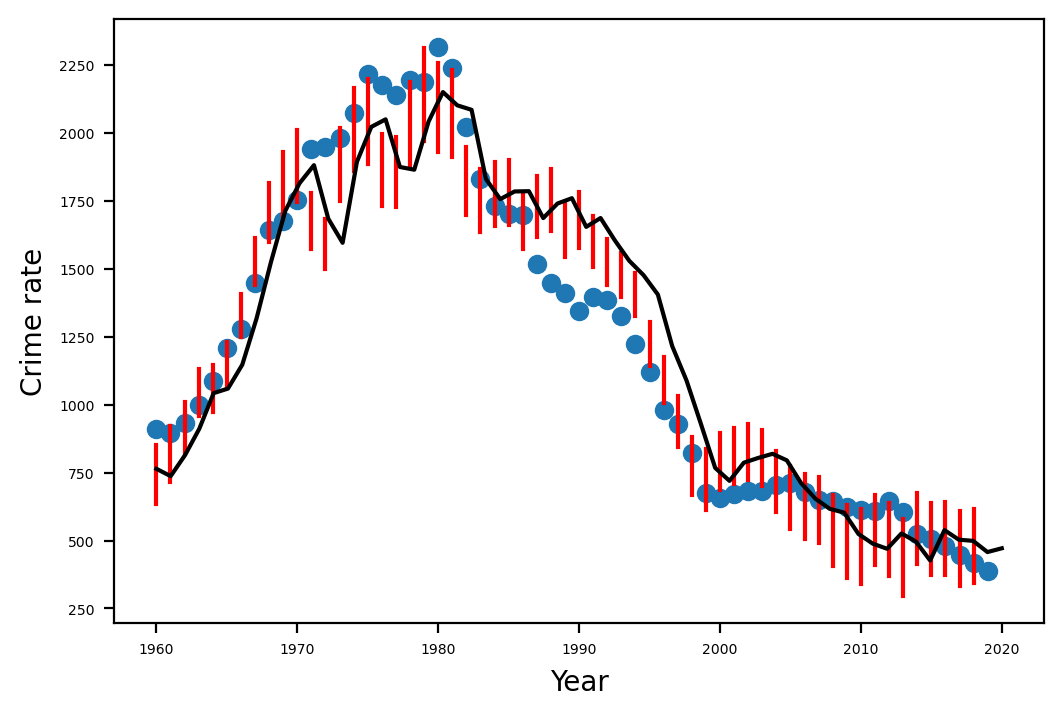

In [66]:
for i in range(1,60):
    v = [i + 1959, i + 1959]
    mu_max = mu_linear_fit[:,i].max()
    mu_min = mu_linear_fit[:,i].min()
    mu = [mu_min, mu_max]
    
    plt.plot(v, mu, color = 'r')
bur_mean = np.mean(burglary_linear_fit, axis = 0)
plt.plot(np.linspace(1960, 2020, 60), bur_mean, color = 'k')
plt.scatter(california['Year'], california['Data.Rates.Property.Burglary'])
plt.xlabel('Year')
plt.ylabel('Crime rate')
plt.show()


The course of the burglary mean is pretty similar to the actual data course.

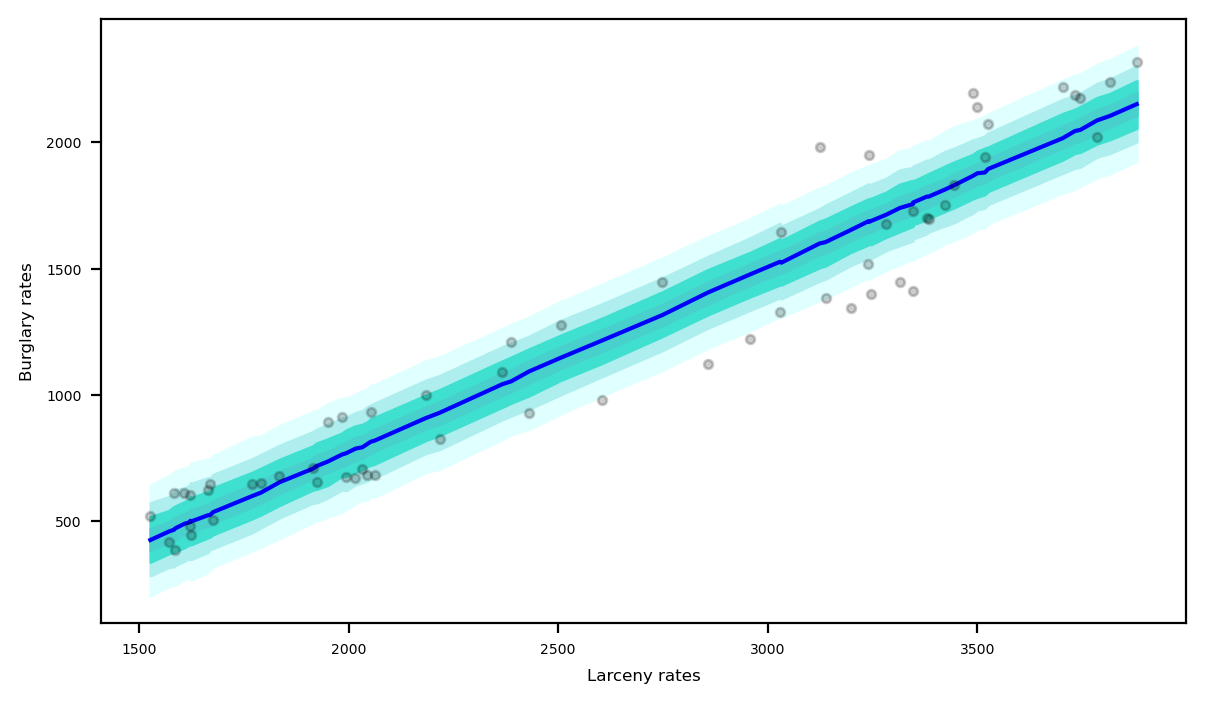

In [34]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))
x_axis = np.array(california['Data.Rates.Property.Larceny'])

axes = ribbon_plot(x_axis, burglary_linear_fit, axes, supress_warning = True)

axes.scatter(california['Data.Rates.Property.Larceny'],california['Data.Rates.Property.Burglary'],
             color='black', alpha = 0.2, s=10)
axes.set_xlabel('Larceny rates', fontsize = 6)
axes.set_ylabel('Burglary rates', fontsize = 6)
plt.show()

The plots of $\alpha$ and $\beta$ parameter show that both parameters are concise and have a normal distribution. 

# 6. Model comparison

Leave-one-out cross-validation (LOO) and the widely applicable information criterion (WAIC) are methods for estimating pointwise out-of-sample prediction accuracy from a fitted Bayesian model using the log-likelihood evaluated at the posterior simulations of the parameter values. 

An information criterion is a measure of the quality of a statistical model. It takes into account:
<br>
-how well the model fits the data,
<br>
-the complexity of the model.

In [35]:
fit_normal_id = az.from_cmdstanpy(posterior = sim_normal_fit, log_likelihood = 'log_lik', 
                                 posterior_predictive = 'burglary', 
                                  observed_data ={'burglaries':california['Data.Rates.Property.Burglary']} )


fit_linear_id = az.from_cmdstanpy(posterior=sim_linear_fit, log_likelihood = 'log_lik', 
                                  posterior_predictive='burglary',
                                   observed_data={'burglaries':california["Data.Rates.Property.Burglary"]})

compare_dict = {'Normal model': fit_normal_id,'Linear model': fit_linear_id}


c:\Users\Agnieszka\anaconda3\envs\data-anatylics\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
c:\Users\Agnieszka\anaconda3\envs\data-anatylics\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


              rank         loo     p_loo      d_loo        weight        se  \
Linear model     0 -393.961439  2.418265   0.000000  1.000000e+00  4.740520   
Normal model     1 -469.659746  1.413319  75.698307  2.648193e-11  3.375807   

                   dse  warning loo_scale  
Linear model  0.000000    False       log  
Normal model  5.929763    False       log  


Text(0.5, 1.0, 'LOO comparison')

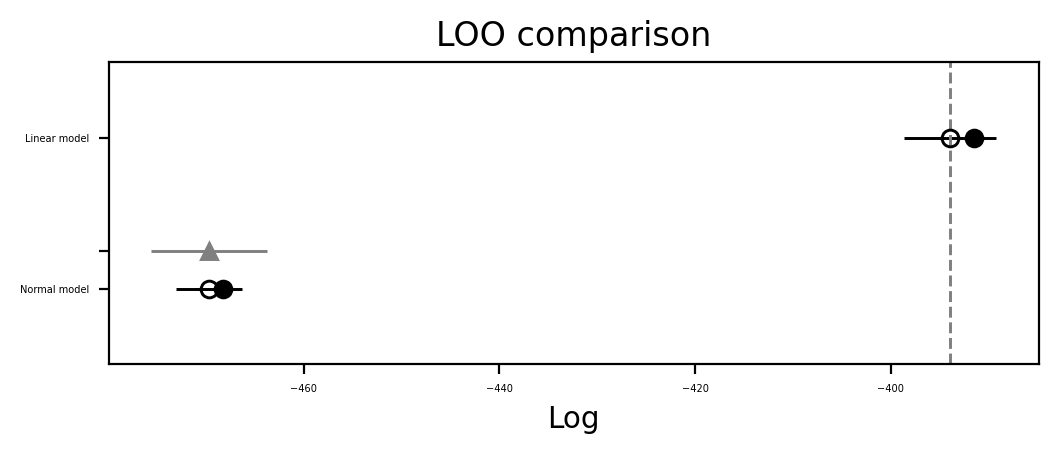

In [38]:
#loo comparision
model_compare_loo = az.compare(compare_dict, ic="loo", method="stacking", scale="log")

print(model_compare_loo.head())
az.plot_compare(model_compare_loo)
plt.title('LOO comparison')

Based on the LOO criteria - taking into consideration:
- linear model has lower rank (which mean the best model),
- it has higher out-of-sample predictive fit ('loo' column),
- has higher probability of the correctness of the model ('weight' column),
- standard error of the difference information criteria (dse) - informs that the difference between models is small.

c:\Users\Agnieszka\anaconda3\envs\data-anatylics\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
c:\Users\Agnieszka\anaconda3\envs\data-anatylics\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


              rank        waic    p_waic     d_waic        weight        se  \
Linear model     0 -393.953810  2.410635   0.000000  1.000000e+00  4.738689   
Normal model     1 -469.658135  1.411708  75.704326  9.649170e-11  3.375427   

                   dse  warning waic_scale  
Linear model  0.000000    False        log  
Normal model  5.928503    False        log  


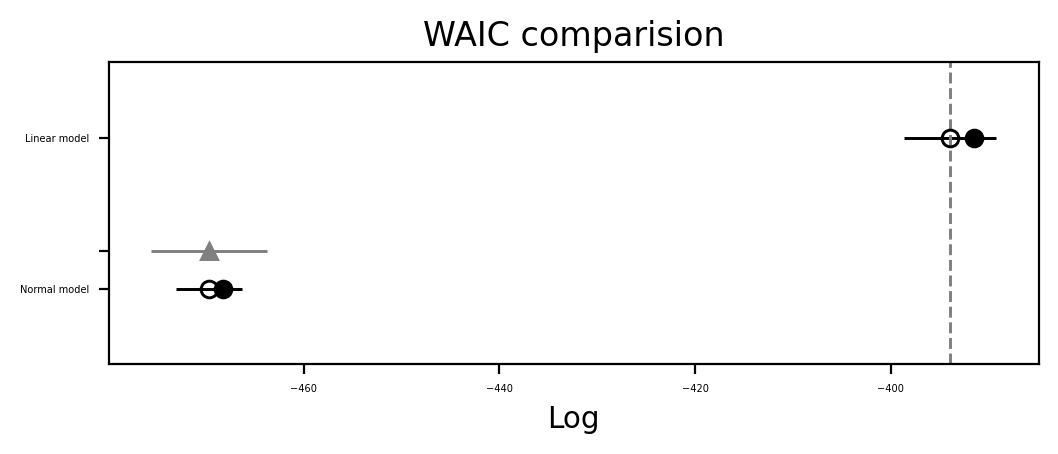

In [36]:
#waic comparision
model_compare_waic = az.compare(dataset_dict=compare_dict, ic='waic')
az.plot_compare(model_compare_waic)
plt.title('WAIC comparision')
print(model_compare_waic.head())


Results from WAIC analysis are simillar to the results from the LOO analysis.

There is no overlap.

Baseed on the comparison of models (visually and by criteria) - we can admit that linear model fits data better even though the difference between the models is not so big. Changing of the parameters of the models will probably show the bigger difference between the models.

As authors we agree with the information criteria. Probably, the model which will map the data better is the model using the spline - which will cover better the actual data course- describing the higher order equation (e.g. fourth order polynomial).
<br>
